In [1]:
import os
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [2]:
data_path = "databases/AffectNet"
df = pd.read_csv(data_path + "/labels.csv")

# Extracting landmark data from dataset

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
"""
#Commented out to avoid running it again    
landmarks = {}

drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.9,
) as face_mesh:
    for row in tqdm(df.itertuples()):
        image = cv2.imread(data_path + "/" + row.pth)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        label = row.label
        results = face_mesh.process(image)

        if results.multi_face_landmarks:
            assert len(results.multi_face_landmarks) == 1
            for face_landmarks in results.multi_face_landmarks:
                l = {}
                for i, landmark in enumerate(face_landmarks.landmark):
                    l[i] = [landmark.x, landmark.y, landmark.z]
                
                landmarks[row.pth] = {}
                landmarks[row.pth]['landmarks'] = list(l.values())
                landmarks[row.pth]['label'] = label

json.dump(landmarks, open(data_path + "/landmarks.json", "w"))"""

'\n#Commented out to avoid running it again    \nlandmarks = {}\n\ndrawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)\nwith mp_face_mesh.FaceMesh(\n    max_num_faces=1,\n    refine_landmarks=True,\n    min_detection_confidence=0.9,\n) as face_mesh:\n    for row in tqdm(df.itertuples()):\n        image = cv2.imread(data_path + "/" + row.pth)\n        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n        image = cv2.resize(image, (256, 256))\n        label = row.label\n        results = face_mesh.process(image)\n\n        if results.multi_face_landmarks:\n            assert len(results.multi_face_landmarks) == 1\n            for face_landmarks in results.multi_face_landmarks:\n                l = {}\n                for i, landmark in enumerate(face_landmarks.landmark):\n                    l[i] = [landmark.x, landmark.y, landmark.z]\n                \n                landmarks[row.pth] = {}\n                landmarks[row.pth][\'landmarks\'] = list(l.values())\n       

In [4]:
landmarks = json.load(open(data_path + "/landmarks.json", "r"))

In [21]:
emotions = list(landmarks.keys())
emotions = [x.split("/")[0] for x in emotions]
label2id = {label: idx for idx, label in enumerate(sorted(set(emotions)))}
id2label = {v: k for k, v in label2id.items()}
label2id

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

In [7]:
counter = np.bincount([label2id[x] for x in emotions])
counter

array([4164, 2212, 1332, 1626, 1339, 1674, 4032, 2000])

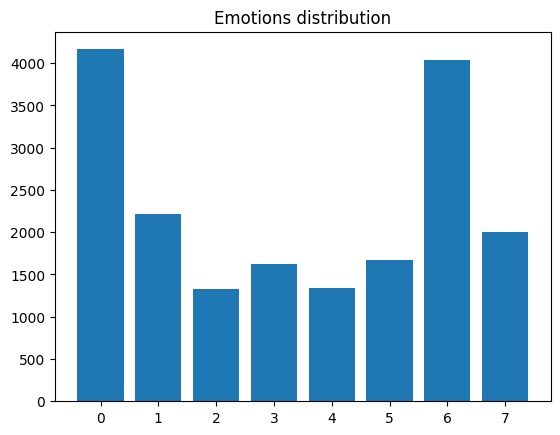

In [8]:
counts = np.bincount([label2id[x] for x in emotions])
plt.bar(range(len(counts)), counts)
plt.xticks(rotation=0)
plt.title("Emotions distribution")
plt.show()

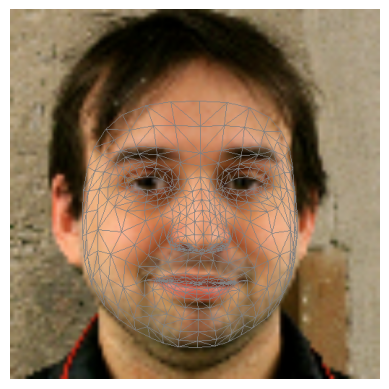

In [9]:
from utils import draw_landmarks

def show_landmarks(landmarks, idx):
    path = list(landmarks.keys())[idx]
    path_label = path.split("/")[0]
    image = cv2.imread(data_path + "/" + path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512, 512))
    l = np.array(landmarks[path]['landmarks'])
    label = landmarks[path]['label']
    draw_landmarks(image, l)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

idx = np.random.randint(len(landmarks))
show_landmarks(landmarks, idx)

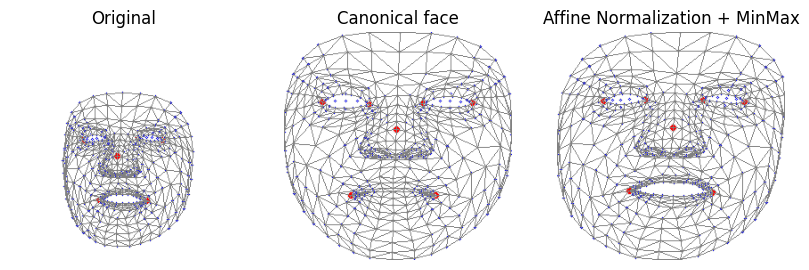

In [10]:
from utils import normalize_face, get_indices_subset, normalize_affine, canonical_face, minmax_scale, subset_indices, draw_landmarks_colored

indices = get_indices_subset()
idx = np.random.choice(list(landmarks.keys()))
landmark = np.array(landmarks[idx]['landmarks'])
affine_transformed = normalize_affine(landmark)
canonical_face = minmax_scale(canonical_face)

image1 = np.ones((256, 256, 3), dtype=np.uint8) * 255
image2 = np.ones((256, 256, 3), dtype=np.uint8) * 255
image3 = np.ones((256, 256, 3), dtype=np.uint8) * 255

image1 = draw_landmarks_colored(image1, landmark, selected_indices=subset_indices, selected_color=(255, 0, 0))
image2 = draw_landmarks_colored(image2, canonical_face, selected_indices=subset_indices, selected_color=(255, 0, 0))
image3 = draw_landmarks_colored(image3, affine_transformed, selected_indices=subset_indices, selected_color=(255, 0, 0))

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(image1)
ax[0].set_title("Original")
ax[1].imshow(image2)
ax[1].set_title("Canonical face")
ax[2].imshow(image3)
ax[2].set_title("Affine Normalization + MinMax")
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

# Dataset

### Defining dataset

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader


class EmotionDataset(Dataset):
    def __init__(
        self, dataset_dict, label2id, normalization_func, indices=None,
    ):
        self.dataset = dataset_dict
        self.landmarks = np.array([x["landmarks"] for x in self.dataset.values()])
        assert self.landmarks.shape[1:] == (478, 3)
        self.landmarks = torch.tensor(
            np.array([normalization_func(x, indices = indices) for x in self.landmarks]),
            dtype=torch.float32,
        )
        self.labels = list(self.dataset.keys())
        self.labels = torch.tensor(
            [label2id[x.split("/")[0]] for x in self.labels], dtype=torch.long
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.landmarks[idx].permute(1, 0), self.labels[idx]


normalization_func = normalize_affine
dataset = EmotionDataset(
    landmarks, label2id, normalization_func, indices
)

In [12]:
dataset[0][0].shape

torch.Size([3, 100])

In [13]:
from torch.utils.data import random_split

def get_loaders(landmarks, normalization_func, label2id, indices=None, batch_size=32, train_size = 0.8):
    dataset = EmotionDataset(landmarks, label2id, normalization_func, indices)
    test_val_size = (1 - train_size) / 2

    gen1 = torch.Generator().manual_seed(42)
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, test_val_size, test_val_size], generator=gen1)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

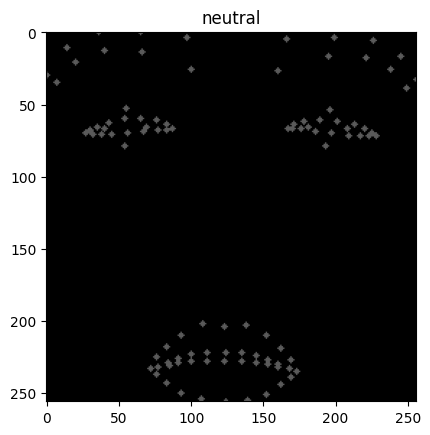

In [14]:
from utils import fast_draw
idx = np.random.randint(len(dataset))
image = np.zeros((256, 256, 3), dtype=np.uint8)
l = dataset[idx][0].clone().detach()
label = dataset[idx][1].clone().detach()
image = fast_draw(image, l)
plt.imshow(image)
plt.title(id2label[label.item()])
plt.show()

# Defining the model

In [15]:
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable

#NOT USED IN THE FINAL VERSION
class ConvSEBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvSEBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(out_channels, out_channels // 16, 1),
            nn.ReLU(),
            nn.Conv1d(out_channels // 16, out_channels, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        se = self.se(x)
        x = x * se
        return x

#NOT USED IN THE FINAL VERSION
class SENet(nn.Module):
    def __init__(self, out_size, dropout_p = 0.1):
        super(SENet, self).__init__()
        self.back = nn.Sequential(
            ConvSEBlock(3, 64, 16, 8, 4),
            nn.MaxPool1d(2),
            ConvSEBlock(64, 128, 8, 4, 4),
            nn.MaxPool1d(2),
            ConvSEBlock(128, 256, 6, 2, 4),
            nn.MaxPool1d(2),
            ConvSEBlock(256, 512, 4, 1, 4),
            nn.MaxPool1d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 3, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, out_size)
        )

    def forward(self, x):
        x = self.back(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#USED IN THE FINAL VERSION
class Net(nn.Module):
    def __init__(self, out_size, dropout_p=0.1):
        super(Net, self).__init__()
        self.back = nn.Sequential(
            nn.Conv1d(3, 64, 8),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Conv1d(64, 128, 6),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Conv1d(128, 256, 4),
            nn.MaxPool1d(2),
            #nn.Dropout1d(0.0),
            nn.ReLU(),
            nn.Conv1d(256, 512, 3),
            nn.MaxPool1d(2),
            #nn.Dropout1d(0.0),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * 3, 256),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, out_size),
        )

        for conv_layer in self.back:
            if isinstance(conv_layer, nn.Conv1d):
                nn.init.kaiming_normal_(conv_layer.weight)
        for fc_layer in self.fc:
            if isinstance(fc_layer, nn.Linear):
                nn.init.kaiming_normal_(fc_layer.weight)

    def forward(self, x):
        x = self.back(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Example usage
model = Net(len(label2id))
device = torch.device("mps")
model = model.to(device)
sample = torch.rand(32, 3, 100).to(device)
print(model(sample).shape)

params = 0
for p in model.parameters():
    params += p.numel()

f"params: {params:,}"

torch.Size([32, 8])


'params: 1,003,336'

In [16]:
counts = np.bincount([label2id[x] for x in emotions])
weights = 1 / counts
weights = weights / weights.sum()
weights = torch.tensor(weights, dtype=torch.float32).to(device)
weights

tensor([0.0579, 0.1089, 0.1809, 0.1482, 0.1799, 0.1439, 0.0598, 0.1205],
       device='mps:0')

In [17]:
from utils import minmax_scale, evaluate, train_model


def multiple_trainings():
    results = {}
    batch_sizes = [128, 256, 512, 1024][::-1]
    normalizations = [normalize_affine, minmax_scale]
    epochs = 5000
    models = [Net]
    for model_class in models:
        for batch_size in batch_sizes:
            for normalization_func in normalizations:
                print(
                    f"Batch size: {batch_size}, Normalization: {normalization_func.__name__}, Model: {type(model_class).__name__}"
                )
                train_loader, val_loader, test_loader = get_loaders(
                    landmarks,
                    normalization_func,
                    label2id,
                    indices,
                    batch_size=batch_size,
                    train_size=0.8,
                )

                model = model_class(len(label2id))
                device = torch.device("mps")
                model = model.to(device)

                criterion = nn.CrossEntropyLoss(weight=weights)
                optimizer = torch.optim.Adam(
                    model.parameters(), lr=0.0005, weight_decay=1e-4
                )
                scheduler = torch.optim.lr_scheduler.LinearLR(
                    optimizer, start_factor=1.0, end_factor=0.1, total_iters=epochs
                )
                #scheduler = None

                sample = next(iter(train_loader))[0]
                batch_size = sample.shape[0]
                logdir = f"logs/{type(model).__name__}_{epochs}_{batch_size}_"
                if sample.shape[-1] < 478:
                    logdir += "subsampled_"

                logdir += "dirlabels_"
                logdir += normalization_func.__name__
                logdir += f"_{time()}"

                save_path = logdir + "/best_model.pth"

                train_losses, val_losses = train_model(
                    model,
                    train_loader,
                    val_loader,
                    criterion,
                    optimizer,
                    scheduler,
                    epochs,
                    device,
                    patience=150,
                    save_path=save_path,
                    logdir=logdir,
                )

                model.load_state_dict(torch.load(save_path, weights_only=True))
                acc, f1, precision, recall, cm = evaluate(model, test_loader, device)
                # print model class name
                res_name = f"{type(model).__name__}_{batch_size}_{normalization_func.__name__}_subsampled"
                print(f"Results for {res_name}:")
                print(
                    f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}"
                )
                print("_" * 50)
                results[res_name] = {
                    "acc": acc,
                    "f1": f1,
                    "precision": precision,
                    "recall": recall,
                    "cm": cm,
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                }
                torch.mps.empty_cache()

    return results


#results = multiple_trainings()
#json.dump(results, open("results.json", "w"))

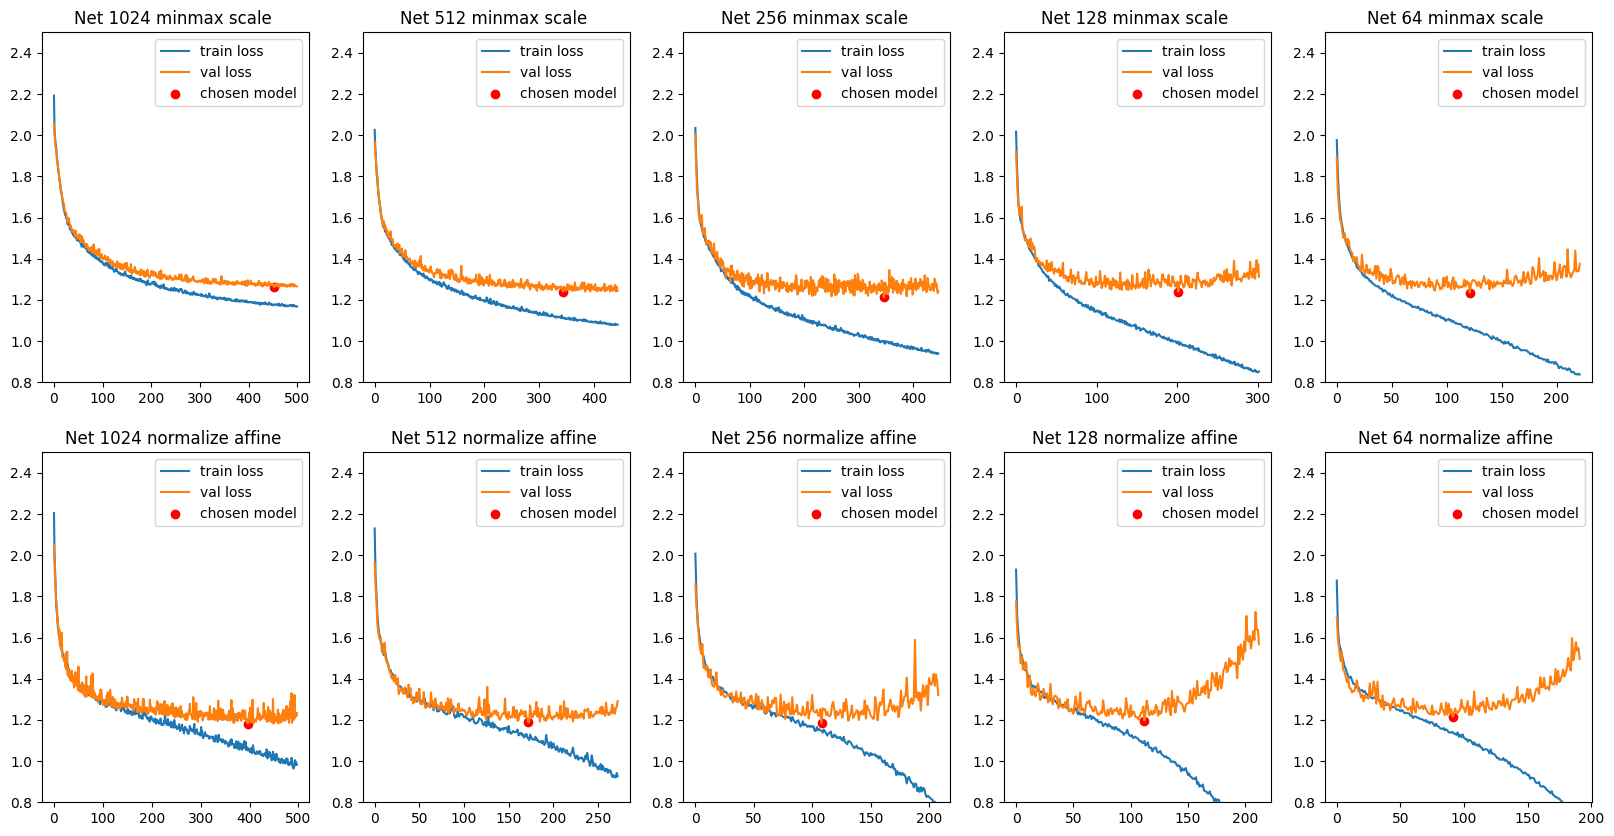

In [25]:
import json
import matplotlib.pyplot as plt
import numpy as np

results = json.load(open("results.json", "r"))

fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, (k, v) in enumerate(results.items()):
    ax[i // 5, i % 5].plot(v["train_losses"], label="train loss")
    ax[i // 5, i % 5].plot(v["val_losses"], label="val loss")
    ax[i // 5, i % 5].set_title(k.replace("subsampled", "").replace("_", " "))
    ax[i // 5, i % 5].scatter(np.argmin(v["val_losses"]), v["val_losses"][np.argmin(v["val_losses"])], color="red", label="chosen model")
    ax[i // 5, i % 5].set_ylim(0.8, 2.5)
    ax[i // 5, i % 5].legend()
plt.show()

In [26]:
import pandas as pd

df = pd.DataFrame(
    columns=["Batch Size", "Normalization", "Accuracy", "F1", "Precision", "Recall"]
)
for key, value in results.items():
    config = (
        key.replace("normalize_affine", "NormalizeAffine")
        .replace("minmax_scale", "MinMaxScale")
        .replace("normalize_face", "NormalizeFace")
        .split("_")
    )
    model_name, batch_size, normalization, subsampled = config
    metrics = [value["acc"], value["f1"], value["precision"], value["recall"]]
    df = pd.concat(
        [df, pd.DataFrame([[batch_size, normalization, *metrics]], columns=df.columns)],
        axis=0,
        ignore_index=True,
    )

df.sort_values("Accuracy", ascending=False)

/var/folders/f1/mgyx72dd65b8kb__4m0rxs_w0000gn/T/ipykernel_63102/1980599411.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


,Batch Size,Normalization,Accuracy,F1,Precision,Recall
5,1024,NormalizeAffine,0.576483,0.548121,0.555402,0.556058
8,128,NormalizeAffine,0.574306,0.543110,0.550816,0.549345
2,256,MinMaxScale,0.560152,0.531241,0.534613,0.540423
9,64,NormalizeAffine,0.558519,0.532637,0.539038,0.540679
7,256,NormalizeAffine,0.556342,0.526440,0.542970,0.536709
6,512,NormalizeAffine,0.555797,0.518591,0.526132,0.533199
4,64,MinMaxScale,0.545999,0.519985,0.525567,0.531066
1,512,MinMaxScale,0.545455,0.515773,0.521051,0.525126
3,128,MinMaxScale,0.544366,0.513799,0.521965,0.525998
0,1024,MinMaxScale,0.534023,0.502124,0.505186,0.507178


In [27]:
def get_best_config(results):
    #this returns the best config for each normalization function
    best_configs = {}
    for normalization_func in ["normalize_affine", "minmax_scale"]:
        best_val = 0
        best_config = None
        for k, v in results.items():
            if normalization_func in k:
                #average metrics
                metrics = np.mean([v["acc"], v["f1"], v["precision"], v["recall"]])
                if metrics > best_val:
                    best_val = metrics
                    best_config = k

        best_configs[normalization_func] = best_config
    
    return best_configs

best_configs = get_best_config(results)
for best in best_configs.values():
    acc, f1, precision, recall = results[best]["acc"], results[best]["f1"], results[best]["precision"], results[best]["recall"]
    print(f"Best config: {best}: Accuracy: {acc:.2f}, F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

Best config: Net_1024_normalize_affine_subsampled: Accuracy: 0.58, F1: 0.55, Precision: 0.56, Recall: 0.56
Best config: Net_256_minmax_scale_subsampled: Accuracy: 0.56, F1: 0.53, Precision: 0.53, Recall: 0.54


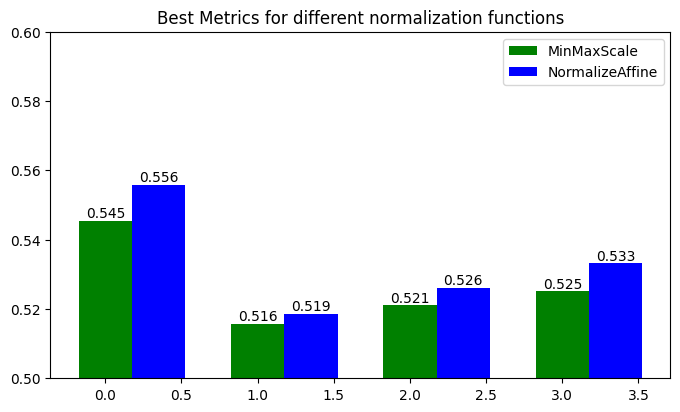

In [28]:
# X locations for the groups
index = np.arange(len(results)//2)
bar_width = 0.35
i = 0
bars = []
colors = ['green', 'blue']
fig, ax = plt.subplots(figsize=(8, 4.5))
for key, value in results.items():
    config = key.replace("normalize_affine", "NormalizeAffine").replace("minmax_scale", "MinMaxScale").split("_")
    model_name, batch_size, normalization, subsampled = config
    if model_name != 'Net' or batch_size != '512':
        continue
    metrics = [value["acc"], value["f1"], value["precision"], value["recall"]]
    bars.append(ax.bar(np.arange(len(metrics)) + (bar_width * i), metrics, bar_width, label=normalization, color=colors[i]))
    i+=1

for bar in bars:
    for i, bar in enumerate(bar):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

plt.legend()
plt.ylim(0.5, 0.6)
plt.title("Best Metrics for different normalization functions")
plt.show()

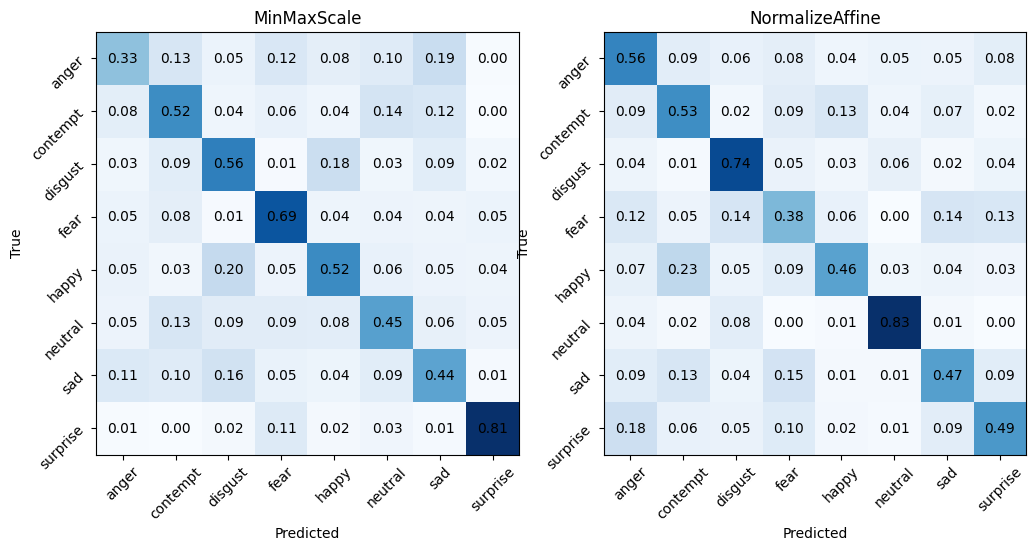

In [30]:
cm_minmax = results[best_configs['minmax_scale']]['cm']
cm_affine = results[best_configs['normalize_affine']]['cm']

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cm_minmax, cmap='Blues')
ax[0].set_title("MinMaxScale")
ax[0].set_xlabel("Predicted")
ax[0].set_xticks(range(len(id2label)))
ax[0].set_xticklabels([id2label[i] for i in range(len(id2label))], rotation=45)
ax[0].set_yticks(range(len(id2label)))
ax[0].set_yticklabels([id2label[i] for i in range(len(id2label))], rotation=45)
ax[0].set_ylabel("True")
ax[1].imshow(cm_affine, cmap='Blues')
ax[1].set_title("NormalizeAffine")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")
ax[1].set_xticks(range(len(id2label)))
ax[1].set_xticklabels([id2label[i] for i in range(len(id2label))], rotation=45)
ax[1].set_yticks(range(len(id2label)))
ax[1].set_yticklabels([id2label[i] for i in range(len(id2label))], rotation=45)

#plot text on top of the confusion matrix
for i in range(len(id2label)):
    for j in range(len(id2label)):
        ax[0].text(j, i, f'{cm_minmax[i][j]:.2f}', ha='center', va='center', color='black')
        ax[1].text(j, i, f'{cm_affine[i][j]:.2f}', ha='center', va='center', color='black')
plt.show()